## News Mood
### Background
As you might know, --Twitter-- has become a wildly sprawling jungle of information&mdash;140 characters at a time. 
Somewhere between 350 million and 500 million tweets are estimated to be sent out _per day_. 
With such an explosion of data, on Twitter and elsewhere, it becomes more important than ever to tame it in 
some way, to concisely capture the essence of the data.

In this activity, we will perform a sentiment analysis of the Twitter activity of various news oulets (BBC, CBS, CNN, Fox, and New York times)
and show the findings providing a visualized summary of the sentiments expressed in Tweets sent out by the newscast above.


## Analysis
#### 1. Based on this sampling data, the majority of these Tweets are positive based on the VADER analysis.
#### 2. CBS is the news cast with the highest positive sentiment follwed by Fox.
#### 3. BBC is the newscast with the majority of the neutral sentiments.

In [ ]:
## Dependencies
import csv
import tweepy
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from datetime import datetime, timezone

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
#Create a Python script to perform a sentiment analysis of the Twitter activity of various news oulets,
#and present your findings visually.
#Your final output should provide a visualized summary of the sentiments expressed in Tweets 
#sent out by the following news organizations: __BBC, CBS, CNN, Fox, and New York times__.

In [3]:
# Target Search Term
target_terms = ("@BBC", "@CBS", "@CNN",
                "@Fox", "@New York Times")
# Counter
counter = 1

# List to hold results
news_list = []

# Loop through all target users
for target in target_terms:

    # Variable for holding the oldest tweet
    oldest_tweet = None

    # Loop through 5 times *****
    for x in range(5):

        # Run search around each tweet
        public_tweets = api.user_timeline(target, max_id = oldest_tweet)
        
        # Loop through all tweets
        for tweet in public_tweets:

            # Print Tweets
            # print("Tweet %s: %s" % (counter, tweet["text"]))
        
            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]
            tweets_ago = counter
        
            # Get Tweet ID, subtract 1, and assign to oldest_tweet
            oldest_tweet = tweet['id'] - 1
            # Convert the date to be used later
            date = tweet["created_at"]
            date_converted = datetime.strptime(date, "%a %b %d %H:%M:%S %z %Y")
            # Add sentiments for each tweet into a list
            news_list.append({"News_Cast" : target,
                            "Date": date_converted, 
                            "Compound": compound,
                            "Positive": pos,
                            "Negative": neu,
                            "Neutral": neg,
                            "Tweets Ago": counter})
        
            # Add to counter 
            counter += 1


In [4]:
# Convert sentiments to DataFrame
news_list_pd = pd.DataFrame.from_dict(news_list)
news_list_pd.head()

,Compound,Date,Negative,Neutral,News_Cast,Positive,Tweets Ago
0,0.0000,2018-06-09 20:04:00+00:00,1.000,0.000,@BBC,0.000,1
1,0.3612,2018-06-09 19:02:05+00:00,0.878,0.000,@BBC,0.122,2
2,0.0000,2018-06-09 18:04:03+00:00,1.000,0.000,@BBC,0.000,3
3,0.5719,2018-06-09 17:01:05+00:00,0.829,0.000,@BBC,0.171,4
4,0.4019,2018-06-09 16:04:03+00:00,0.623,0.156,@BBC,0.222,5


In [5]:
len(news_list_pd)

412

In [6]:
# Save as a csv using "utf-8" encoding
news_list_pd.to_csv("newscast_sentiments.csv", encoding="utf-8", index=False)

In [7]:
by_newscast = news_list_pd.groupby('News_Cast')

pos_count = news_list_pd[news_list_pd['Compound'] > 0].groupby('News_Cast')['Compound'].count()
neg_count = news_list_pd[news_list_pd['Compound'] < 0].groupby('News_Cast')['Compound'].count()
neu_count = news_list_pd[news_list_pd['Compound'] == 0].groupby('News_Cast')['Compound'].count()

polarity_df = pd.DataFrame({
    "Positive Compound Scores": pos_count,
    "Negative Compound Scores": neg_count,
    "Neutral Compound Scores": neu_count,
    "Total": pos_count + neg_count + neu_count
})
polarity_df

,Negative Compound Scores,Neutral Compound Scores,Positive Compound Scores,Total
News_Cast,,,,
@BBC,24,32,44,100
@CBS,10,24,66,100
@CNN,26,31,43,100
@Fox,15,24,61,100
@New York Times,1,6,5,12


In [8]:
bbc_compound = news_list_pd.groupby('News_Cast')['Compound'].mean()
bbc_compound

News_Cast
@BBC               0.120679
@CBS               0.326564
@CNN               0.093054
@Fox               0.273989
@New York Times    0.247308
Name: Compound, dtype: float64

In [9]:
neg_sum = polarity_df['Negative Compound Scores'].sum()
neu_sum = polarity_df['Neutral Compound Scores'].sum()
pos_sum = polarity_df['Positive Compound Scores'].sum()
total = neg_sum + pos_sum + neu_sum

sentiments_df = pd.DataFrame({
    "Total Negative": [neg_sum],
    "Total Positive": pos_sum,
    "Total Neutral": neg_sum,
    "Total": total
})

sentiments_df

,Total,Total Negative,Total Neutral,Total Positive
0,412,76,76,219


In [10]:
time_max = by_newscast['Date'].max()
time_min = by_newscast['Date'].min()
time_diff = time_max - time_min
time_diff

avg_time_per_tweets = time_diff/100
time_df = pd.DataFrame({
    "Time passed between 1 and 100 Tweets": time_diff,
    "Average Time Between Tweets": avg_time_per_tweets
})

time_df

,Average Time Between Tweets,Time passed between 1 and 100 Tweets
News_Cast,,
@BBC,01:17:51.570000,5 days 09:45:57
@CBS,13:00:34.330000,54 days 04:57:13
@CNN,00:13:12.390000,0 days 22:00:39
@Fox,02:43:17.280000,11 days 08:08:48
@New York Times,02:10:23.170000,9 days 01:18:37


In [11]:
#finds date of most recent and least recent tweet
date_max = news_list_pd['Date'].max().replace(tzinfo=timezone.utc).astimezone(tz = 'US/Eastern').strftime('%D: %r') + " (ET)"
date_min = news_list_pd['Date'].min().replace(tzinfo=timezone.utc).astimezone(tz = 'US/Eastern').strftime('%D: %r') + " (ET)"

In [12]:
by_newscast.head()

,Compound,Date,Negative,Neutral,News_Cast,Positive,Tweets Ago
0,0.0000,2018-06-09 20:04:00+00:00,1.000,0.000,@BBC,0.000,1
1,0.3612,2018-06-09 19:02:05+00:00,0.878,0.000,@BBC,0.122,2
2,0.0000,2018-06-09 18:04:03+00:00,1.000,0.000,@BBC,0.000,3
3,0.5719,2018-06-09 17:01:05+00:00,0.829,0.000,@BBC,0.171,4
4,0.4019,2018-06-09 16:04:03+00:00,0.623,0.156,@BBC,0.222,5
100,0.6800,2018-06-09 21:00:02+00:00,0.763,0.000,@CBS,0.237,101
101,0.0000,2018-06-09 16:00:00+00:00,1.000,0.000,@CBS,0.000,102
102,0.2960,2018-06-08 19:46:17+00:00,0.820,0.000,@CBS,0.180,103
103,0.0000,2018-06-08 15:00:03+00:00,1.000,0.000,@CBS,0.000,104
104,0.9078,2018-06-08 13:58:15+00:00,0.564,0.000,@CBS,0.436,105


In [13]:
# Assign variables to the different News Cast Companies
bbc = news_list_pd[news_list_pd["News_Cast"] == "@BBC"]
cbs = news_list_pd[news_list_pd["News_Cast"] == "@CBS"]
cnn = news_list_pd[news_list_pd["News_Cast"] == "@CNN"]
fox = news_list_pd[news_list_pd["News_Cast"] == "@Fox"]
nyt = news_list_pd[news_list_pd["News_Cast"] == "@New York Times"]

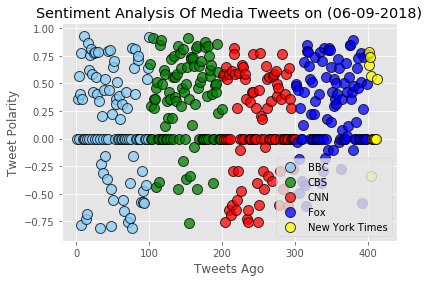

In [14]:
# Creating base chart - Including chart tittle, axis labels, notation
now = datetime.now()
now = now.strftime("%m-%d-%Y")
plt.title(f"Sentiment Analysis Of Media Tweets on ({now})")
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity")
# Add the Grid and use gray as the grid Color
plt.rc('grid', linestyle="-", color='gray')
plt.grid(True)
# Create the Scatter Plot
x_bbc= bbc['Tweets Ago']
y_bbc= bbc['Compound']
x_cbs= cbs['Tweets Ago']
y_cbs= cbs['Compound']
x_cnn= cnn['Tweets Ago']
y_cnn= cnn['Compound']
x_fox= fox['Tweets Ago']
y_fox= fox['Compound']
x_nyt= nyt['Tweets Ago']
y_nyt= nyt['Compound']
plt.scatter(x_bbc, y_bbc, s = 100, c="lightskyblue", edgecolor= "black", linewidth=1, 
            alpha = 0.75, label = "BBC")
plt.scatter(x_cbs, y_cbs, s = 100, c="green", edgecolor= "black", linewidth=1, alpha = 0.75, 
           label = "CBS")
plt.scatter(x_cnn, y_cnn, s = 100, c="red", edgecolor= "black", linewidth=1, 
            alpha = 0.75, label = "CNN")
plt.scatter(x_fox, y_fox, s = 100, c="blue", edgecolor= "black", linewidth=1, 
            alpha = 0.75, label = "Fox")
plt.scatter(x_nyt, y_nyt, s = 100, c="yellow", edgecolor= "black", linewidth=1, alpha = 0.75, 
           label = "New York Times")
plt.legend()

# Saving the plot
plt.savefig("Sentiment_Analysis.png")

# Showing the plot
plt.show()

In [15]:
bbc_compound = news_list_pd.groupby('News_Cast')['Compound'].mean()
bbc_compound

News_Cast
@BBC               0.120679
@CBS               0.326564
@CNN               0.093054
@Fox               0.273989
@New York Times    0.247308
Name: Compound, dtype: float64

/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/plotting/_core.py:186: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


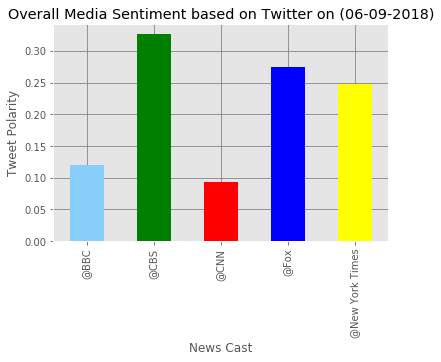

In [16]:
# Creating Bar Chart showing Overall Media Sentiment
overall_chart = bbc_compound.plot(kind='bar', colors=['lightskyblue', 'green', "red", 'blue', 'yellow'])

# Set the xlabel and ylabel using class methods
plt.title(f"Overall Media Sentiment based on Twitter on ({now})")
overall_chart.set_xlabel("News Cast")
overall_chart.set_ylabel("Tweet Polarity")

# Saving the plot
plt.savefig("overall_Sentiment.png")

# Showing the plot
plt.show()

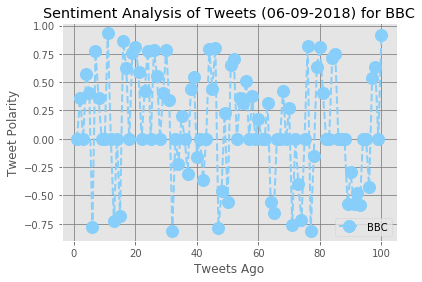

In [17]:
# Create plot chart for BBC
now = datetime.now()
now = now.strftime("%m-%d-%Y")
plt.title(f"Sentiment Analysis of Tweets ({now}) for BBC")
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity")
# Add the Grid and use gray as the grid Color
#plt.rc('grid', linestyle="-", color='gray')
#plt.grid(True)
# Create the Plot
x_bbc= bbc['Tweets Ago']
y_bbc= bbc['Compound']
plt.plot(x_bbc, y_bbc, color='lightskyblue', marker='o', linestyle='dashed', linewidth=2, markersize=12, label = "BBC")
plt.legend()

# Saving the plot
plt.savefig("bbc.png")

# Showing the plot
plt.show()

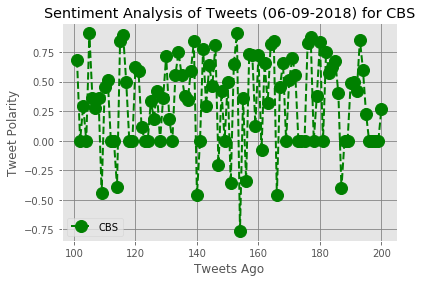

In [18]:
# Create plot chart for CBS
now = datetime.now()
now = now.strftime("%m-%d-%Y")
plt.title(f"Sentiment Analysis of Tweets ({now}) for CBS")
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity")
# Add the Grid and use gray as the grid Color
plt.rc('grid', linestyle="-", color='gray')
plt.grid(True)
# Create the Plot
x_cbs= cbs['Tweets Ago']
y_cbs= cbs['Compound']
plt.plot(x_cbs, y_cbs, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12, label = "CBS")
plt.legend()

# Saving the plot
plt.savefig("cbs.png")

# Showing the plot
plt.show()

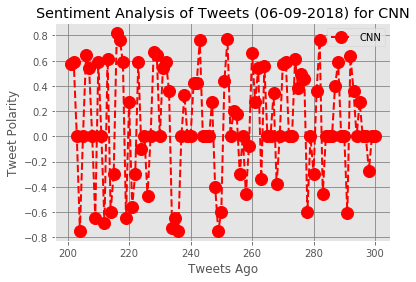

In [19]:
# Create plot chart for CNN
now = datetime.now()
now = now.strftime("%m-%d-%Y")
plt.title(f"Sentiment Analysis of Tweets ({now}) for CNN")
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity")
# Add the Grid and use gray as the grid Color
plt.rc('grid', linestyle="-", color='gray')
plt.grid(True)
# Create the Plot
x_cnn= cnn['Tweets Ago']
y_cnn= cnn['Compound']
plt.plot(x_cnn, y_cnn, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=12, label = "CNN")
plt.legend()

# Saving the plot
plt.savefig("cnn.png")

# Showing the plot
plt.show()

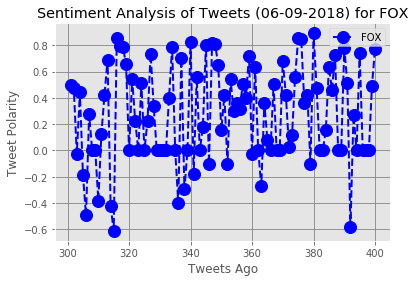

In [20]:
# Create plot chart for FOX
now = datetime.now()
now = now.strftime("%m-%d-%Y")
plt.title(f"Sentiment Analysis of Tweets ({now}) for FOX")
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity")
# Add the Grid and use gray as the grid Color
plt.rc('grid', linestyle="-", color='gray')
plt.grid(True)
# Create the Plot
x_fox= fox['Tweets Ago']
y_fox= fox['Compound']
plt.plot(x_fox, y_fox, color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=12, label = "FOX")
plt.legend()

# Saving the plot
plt.savefig("fox.png")

# Showing the plot
plt.show()

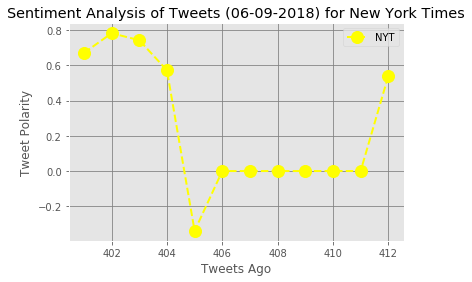

In [21]:
# Create plot chart for New York Times
now = datetime.now()
now = now.strftime("%m-%d-%Y")
plt.title(f"Sentiment Analysis of Tweets ({now}) for New York Times")
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity")
# Add the Grid and use gray as the grid Color
plt.rc('grid', linestyle="-", color='gray')
plt.grid(True)
# Create the Plot
x_nyt= nyt['Tweets Ago']
y_nyt= nyt['Compound']
plt.plot(x_nyt, y_nyt, color='yellow', marker='o', linestyle='dashed', linewidth=2, markersize=12, label = "NYT")
plt.legend()

# Saving the plot
plt.savefig("newyorktimes.png")

# Showing the plot
plt.show()